In [1]:
import time
import torch
from torch.distributions import Categorical, kl
from d2l.torch import Animator

from rcpsp_inst import RCPSPInstance, load_dataset
from net import Net
from aco import ACO_RCPSP
import random

# torch.manual_seed(1234)

lr = 1e-5
EPS = 1e-10
ALPHA = 0.05
T=5
device = 'cpu'

In [2]:
def train_instance(model, optimizer, rcpsp: RCPSPInstance, n_ants):
    model.train()
    pyg_data = rcpsp.to_pyg_data()
    phe_vec, heu_vec = model(pyg_data, require_phe=True, require_heu=True)
    phe_mat, heu_mat = model.reshape(pyg_data, phe_vec) + EPS, model.reshape(pyg_data, heu_vec) + EPS
    
    aco = ACO_RCPSP(
        rcpsp,
        n_ants=n_ants,
        pheromone=phe_mat,
        heuristic=heu_mat,
        device=device,
        train = True
    )
    
    costs, log_probs = aco.sample()
    assert log_probs is not None
    assert pyg_data.num_nodes is not None
    baseline = costs.mean()
    reinforce_loss = torch.sum((costs - baseline) * log_probs.sum(dim=0)) / aco.n_ants
    k_sparse = pyg_data.num_edges // pyg_data.num_nodes
    entropy_loss = ALPHA * (-torch.sum(Categorical(phe_mat).entropy()) / k_sparse)
    # print(reinforce_loss.item(), entropy_loss.item())
    loss = reinforce_loss + entropy_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def infer_instance(model, rcpsp, n_ants):
    model.eval()
    pyg_data = rcpsp.to_pyg_data()
    phe_vec, heu_vec = model(pyg_data, require_phe=True, require_heu=True)
    phe_mat, heu_mat = model.reshape(pyg_data, phe_vec) + EPS, model.reshape(pyg_data, heu_vec) + EPS
    aco = ACO_RCPSP(
        rcpsp,
        n_ants=n_ants,
        pheromone=phe_mat,
        heuristic=heu_mat,
        device=device,
        train = True
    )
    costs, log_probs = aco.sample()
    result = aco.run(n_iterations=T)
    baseline = costs.mean()
    best_sample_cost = torch.min(costs)
    best_aco_cost = result.cost
    return baseline.item(), best_sample_cost.item(), best_aco_cost

In [3]:
def train_epoch(trainset,
                n_ants, 
                steps_per_epoch, 
                net, 
                optimizer
                ):
    losses = []
    for _ in range(steps_per_epoch):
        data = trainset[random.randint(0,len(trainset)-1)]
        loss = train_instance(net, optimizer, data, n_ants)
        losses.append(loss)
    return losses

@torch.no_grad()
def validation(n_ants, epoch, net, val_dataset, animator=None):
    sum_bl, sum_sample_best, sum_aco_best = 0, 0, 0
    
    for instance in val_dataset:
        bl, sample_best, aco_best = infer_instance(net, instance, n_ants)
        sum_bl += bl; sum_sample_best += sample_best; sum_aco_best += aco_best
    
    n_val = len(val_dataset)
    avg_bl, avg_sample_best, avg_aco_best = sum_bl/n_val, sum_sample_best/n_val, sum_aco_best/n_val
    if animator:
        animator.add(epoch+1, (avg_bl, avg_sample_best, avg_aco_best))
    
    return avg_bl, avg_sample_best, avg_aco_best

In [4]:
def train(n_node, n_ants, steps_per_epoch, epochs):
    net = Net().to(device)
    trainset, testset = load_dataset(f"../data/rcpsp/j{n_node}rcp")
    testset = testset[:20]
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    animator = Animator(xlabel='epoch', xlim=[0, epochs],
                        legend=["Avg. sample obj.", "Best sample obj.", "Best ACO obj."])
    
    avg_bl, avg_best, avg_aco_best = validation(n_ants, -1, net, testset, animator)
    val_results = [(avg_bl, avg_best, avg_aco_best)]
    loss_list = []
    
    sum_time = 0
    for epoch in range(0, epochs):
        start = time.time()
        losses = train_epoch(trainset, n_ants, steps_per_epoch, net, optimizer)
        sum_time += time.time() - start
        avg_bl, avg_sample_best, avg_aco_best = validation(n_ants, epoch, net, testset, animator)
        val_results.append((avg_bl, avg_sample_best, avg_aco_best))
        loss_list.append(sum(losses))
        
    print('total training duration:', sum_time)
    for epoch in range(epochs):
        print(f'[epoch {epoch}] loss:', loss_list[epoch], "val:", val_results[epoch])

    torch.save(net.state_dict(), f'../pretrained/rcpsp/rcpsp{n_node}-{net.emb_net.feats}.pt')

total training duration: 159.08573198318481
[epoch 0] loss: 125.27449932694435 val: (83.5800006866455, 71.4, 68.2)
[epoch 1] loss: 146.24812477827072 val: (83.77499961853027, 72.65, 67.55)
[epoch 2] loss: 144.46438105404377 val: (80.46999969482422, 69.75, 65.6)
[epoch 3] loss: 73.22584953904152 val: (80.58999977111816, 70.75, 64.55)
[epoch 4] loss: 160.06448617577553 val: (78.48000030517578, 67.55, 64.4)
[epoch 5] loss: 92.58861804008484 val: (79.27499923706054, 69.8, 65.2)
[epoch 6] loss: 86.46895924210548 val: (78.84500007629394, 68.8, 64.75)
[epoch 7] loss: 138.08300054073334 val: (79.25000038146973, 68.9, 63.95)
[epoch 8] loss: 113.82957947254181 val: (78.57499961853027, 69.25, 64.15)
[epoch 9] loss: 75.60714876651764 val: (78.61500034332275, 68.6, 64.05)
[epoch 10] loss: 148.94172793626785 val: (77.47500076293946, 66.8, 63.9)
[epoch 11] loss: 40.01317085325718 val: (77.77500057220459, 67.9, 63.9)
[epoch 12] loss: 147.67187067866325 val: (77.77500114440917, 67.25, 63.8)
[epoch 13] 

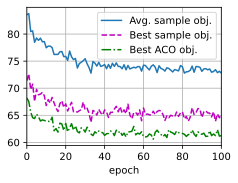

In [5]:
# j30
n_node, n_ants = 30, 10
steps_per_epoch = 32
epochs = 100
train(n_node, n_ants, steps_per_epoch, epochs)

total training duration: 281.73245000839233
[epoch 0] loss: 1547.1755760908127 val: (134.2199993133545, 115.45, 109.75)
[epoch 1] loss: 1312.8681259155273 val: (135.61500053405763, 115.85, 108.3)
[epoch 2] loss: 943.9088072776794 val: (133.989998626709, 115.45, 108.05)
[epoch 3] loss: 1239.3796520233154 val: (134.10000038146973, 115.65, 106.75)
[epoch 4] loss: 1176.0603387355804 val: (133.92500114440918, 115.15, 106.6)
[epoch 5] loss: 1070.7641631364822 val: (133.7850028991699, 115.9, 105.05)
[epoch 6] loss: 908.4006175994873 val: (130.8750015258789, 114.05, 104.95)
[epoch 7] loss: 879.9926498830318 val: (130.49499969482423, 113.2, 104.7)
[epoch 8] loss: 806.0897365361452 val: (127.62499923706055, 108.95, 102.6)
[epoch 9] loss: 687.1380113363266 val: (127.22500038146973, 110.65, 103.0)
[epoch 10] loss: 852.0503838062286 val: (126.59999961853028, 109.95, 103.45)
[epoch 11] loss: 523.9513002634048 val: (126.18999862670898, 108.45, 102.35)
[epoch 12] loss: 858.6073638796806 val: (125.3000

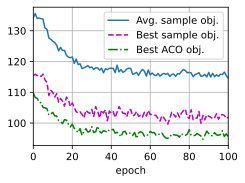

In [6]:
# j60
n_node, n_ants = 60, 10
steps_per_epoch = 32
epochs = 100
train(n_node, n_ants, steps_per_epoch, epochs)

total training duration: 657.84059715271
[epoch 0] loss: 2142.0794382095337 val: (264.77499923706057, 239.95, 232.25)
[epoch 1] loss: 1638.6756641864777 val: (264.37499847412107, 242.7, 231.6)
[epoch 2] loss: 1892.160228729248 val: (252.61999969482423, 232.65, 223.15)
[epoch 3] loss: 1868.2740993499756 val: (250.95000152587892, 229.3, 221.4)
[epoch 4] loss: 2308.729404449463 val: (248.42499923706055, 229.25, 218.2)
[epoch 5] loss: 2187.714461326599 val: (246.64499740600587, 226.1, 218.2)
[epoch 6] loss: 1874.307489156723 val: (248.3300018310547, 229.15, 220.25)
[epoch 7] loss: 2084.8895654678345 val: (247.70000152587892, 228.6, 220.3)
[epoch 8] loss: 1726.1116511821747 val: (245.71999893188476, 224.8, 218.15)
[epoch 9] loss: 2007.3630534410477 val: (246.60499801635743, 229.15, 218.7)
[epoch 10] loss: 1991.8965201377869 val: (247.33000106811522, 227.95, 218.45)
[epoch 11] loss: 1590.7464153766632 val: (244.74999923706054, 225.0, 216.15)
[epoch 12] loss: 2285.300151348114 val: (244.77999

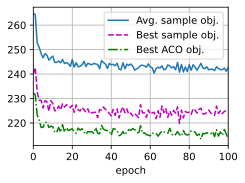

In [7]:
# j120
n_node, n_ants = 120, 10
steps_per_epoch = 32
epochs = 100
train(n_node, n_ants, steps_per_epoch, epochs)